In [5]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

import utils

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [6]:
! ls ../Feb22_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100

QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD_Pt_300to470                         WW
QCD_Pt_3200toInf       

# Read parquets
- loads parquet dataframes and combine different pt-bins per sample
- applies a specified preselection
- saves the combined dataframe under `events[ch][sample]`

In [7]:
year = "2017"
channels = ["mu", "ele"]

samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

In [8]:
events_dict = {}

for ch in channels:
    print("-------------------------------------------")
    print(f"{ch} channel")
    events_dict[ch] = {}
    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch][year]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        not_empty = len(data) > 0

        # get event_weight
        print("---> Accumulating event weights.")                
        event_weight = utils.get_xsecweight(pkl_files, year, sample, False, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
                print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]
        data["event_weight"] = event_weight
        print("---> Done with accumulating event weights.")                       

        print(f"Will fill the {sample_to_use} dataframe with the remaining {len(data)} events")
        print(f"tot event weight {data['event_weight'].sum()} \n")

        # fill the big dataframe
        if sample_to_use not in events_dict[ch].keys():
            events_dict[ch][sample_to_use] = data
        else:
            events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])

-------------------------------------------
mu channel
Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 964 events
tot event weight 1567.6018080746474 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 9908 events
tot event weight 100.02825996279239 

Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VBF dataframe with the remaining 1177 events
tot event weight 58.02846654329544 

Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
---> Accumulating event weights.
weight_vjets_nominal 

---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the TTbar dataframe with the remaining 42758 events
tot event weight 5140.493743924925 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 19732 events
tot event weight 299.9065435179361 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 14340 events
tot event weight 4603.843468895331 

Finding QCD_Pt_300to470 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event 

Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 70292 events
tot event weight 31572.694080212714 

Finding ST_tW_top_5f_inclusiveDecays samples and should combine them under SingleTop
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the SingleTop dataframe with the remaining 8231 events
tot event weight 1806.3358022135292 

Finding WplusHToTauTau samples and should combine them under WplusHToTauTau
No parquet file for WplusHToTauTau
Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the HWW dataframe with the remaining 9649 events
tot event weight 75.71610135703571 

Finding WJ

<ipython-input-8-8896036c83c5>:52: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])
<ipython-input-8-8896036c83c5>:52: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])


---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 390 events
tot event weight 48243.76753175679 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 114528 events
tot event weight 12628.664105695776 

Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 1018 events
tot event weight 223.0537718485731 

Finding GluGluHToWWToLNuQQ samples and should combine them under Diboson
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the Diboson dataframe with the remaining 8968 events
tot eve

<ipython-input-8-8896036c83c5>:52: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])
<ipython-input-8-8896036c83c5>:52: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])


---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1844 events
tot event weight 95.19430643025503 

Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQ
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WZQQ dataframe with the remaining 154 events
tot event weight 333.0520193453809 

Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> Accumulating event weights.
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 65464 events
tot event weight 30339.138785072722 

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1281 events
tot event weight 14

<ipython-input-8-8896036c83c5>:52: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data])


---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the VH dataframe with the remaining 12573 events
tot event weight 13.437891461174738 

Finding WZ samples and should combine them under Diboson
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the Diboson dataframe with the remaining 1186 events
tot event weight 151.25178629313137 

Finding QCD_Pt_1400to1800 samples and should combine them under QCD
---> Accumulating event weights.
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1415 events
tot event weight 3.3541992775945144 

Finding VBFHToTauTau samples and should combine them under VBFHToTauTau
No parquet file for VBFHToTauTau
Finding DYJetsToLL_Pt-100To250 samples and should combine them under DYJets
---> Accumul

In [9]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [10]:
events_dict['mu'].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttHToNonbb_M125'])

# Mass regression

fj_ParT_mass
Found 2708 NaN scores out of 14901 for sample HWW. Will remove them.
Found 40459 NaN scores out of 1463832 for sample TTbar. Will remove them.
Found 5954 NaN scores out of 93431 for sample QCD. Will remove them.


NameError: name 'xch' is not defined

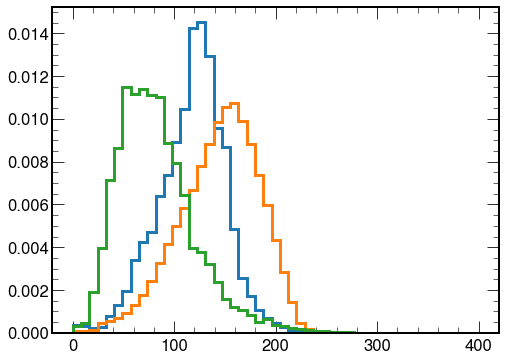

In [11]:
plt.rcParams.update({"font.size": 20})
samples_to_plot = ["HWW", "TTbar", "QCD"]

ch = "mu"

### regressed mass
PNs = ["ParT","ParticleNet"]

for pn_version in PNs:
    
    fig, ax = plt.subplots(figsize=(8, 6))
    bins_ = np.linspace(0,400)
    mass_ = f"fj_{pn_version}_mass"
    print(mass_)
    for sample in samples_to_plot:
        
        X = events_dict[ch][sample][mass_].values
        weights = events_dict[ch][sample]["event_weight"].values
        is_nan = np.isnan(X)
        if is_nan.sum()!=0:
            print(f"Found {is_nan.sum()} NaN scores out of {len(X)} for sample {sample}. Will remove them.")
            X = X[~is_nan]
            weights = weights[~is_nan]

        ax.hist(
            X,
            bins_,
            label=sample,
            linewidth=3,
            density=True,
            histtype="step",
            weights=weights
        )    
    ax.legend(title=f"{xch} channel")
    ax.set_ylabel("Events")
    ax.set_xlabel(f"{mass_} (GeV)");
    print("-------------------------------------")
    
### softdrop mass
fig, ax = plt.subplots(figsize=(8, 6))
bins_ = np.linspace(0,400)
mass_ = "fj_msoftdrop"
print(mass_)
for sample in samples_to_plot:
    ax.hist(
        events_dict[ch][sample][mass_].values,
        bins_,
        label=sample,
        linewidth=3,
        density=True,
        histtype="step",
        weights=events_dict[ch][sample]["event_weight"].values
    )    
ax.legend(title=f"{xch} channel")
ax.set_ylabel("Events")
ax.set_xlabel(f"{mass_} (GeV)");

# Comparing all networks

In [448]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

Found 2708 NaN scores out of 14901. Will remove them.
Found 2708 NaN scores out of 14901. Will remove them.


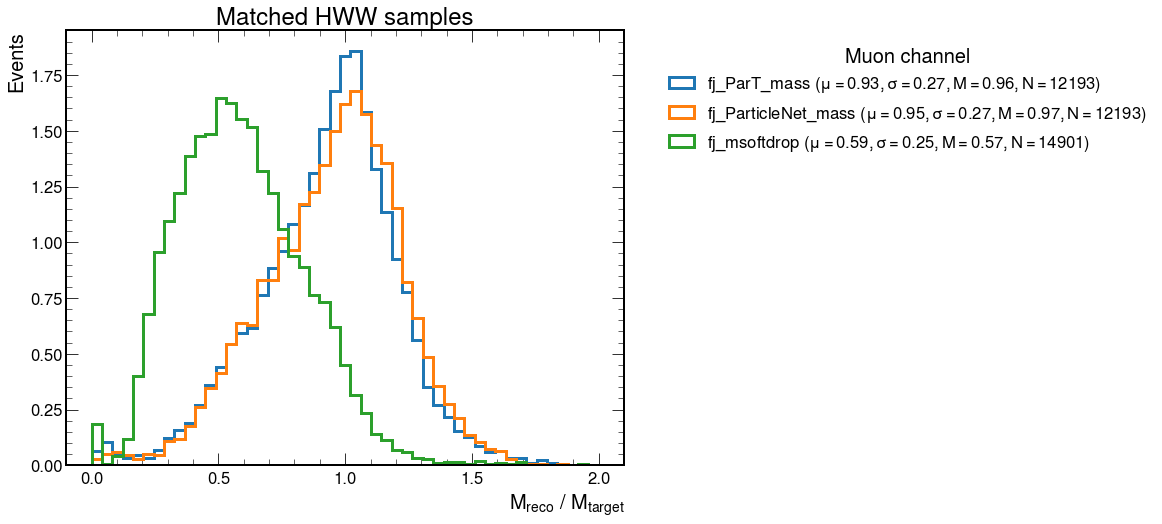

In [463]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

PNs = ["ParT","ParticleNet"]
for pn_version in PNs:
    
    match_bool = events_dict[ch]["HWW"]["fj_H_VV_isMatched"].values

    X = events_dict[ch]["HWW"][f"fj_{pn_version}_mass"][match_bool].values/125
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
    
    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="fj_{}_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(pn_version, np.mean(X), np.std(X), p[0], n_matched),    
        linewidth=3,
        density=True,
        histtype="step"
        )

X = events_dict[ch]["HWW"]["fj_msoftdrop"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Matched HWW samples");

Found 38496 NaN scores out of 1389953. Will remove them.
Found 38073 NaN scores out of 1389953. Will remove them.


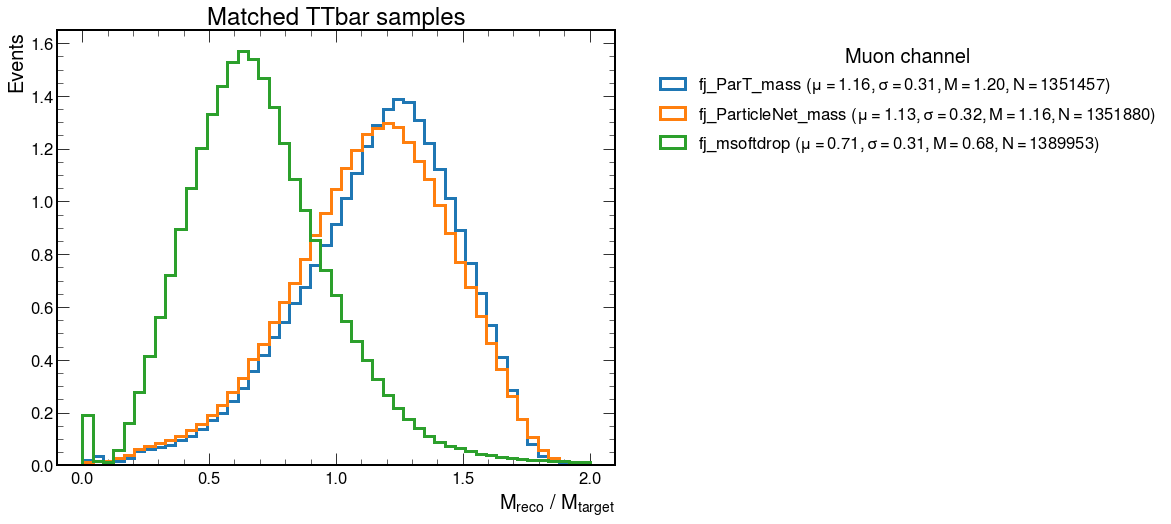

In [464]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

PNs = ["ParT","ParticleNet"]
for pn_version in PNs:
    
    match_bool = events_dict[ch]["TTbar"]["fj_Top_isMatched"].values

    X = events_dict[ch]["TTbar"][f"fj_{pn_version}_mass"][match_bool].values/125
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
    
    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="fj_{}_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(pn_version, np.mean(X), np.std(X), p[0], n_matched),    
        linewidth=3,
        density=True,
        histtype="step"
        )

X = events_dict[ch]["TTbar"]["fj_msoftdrop"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Matched TTbar samples");

Found 1963 NaN scores out of 73879. Will remove them.
Found 1936 NaN scores out of 73879. Will remove them.


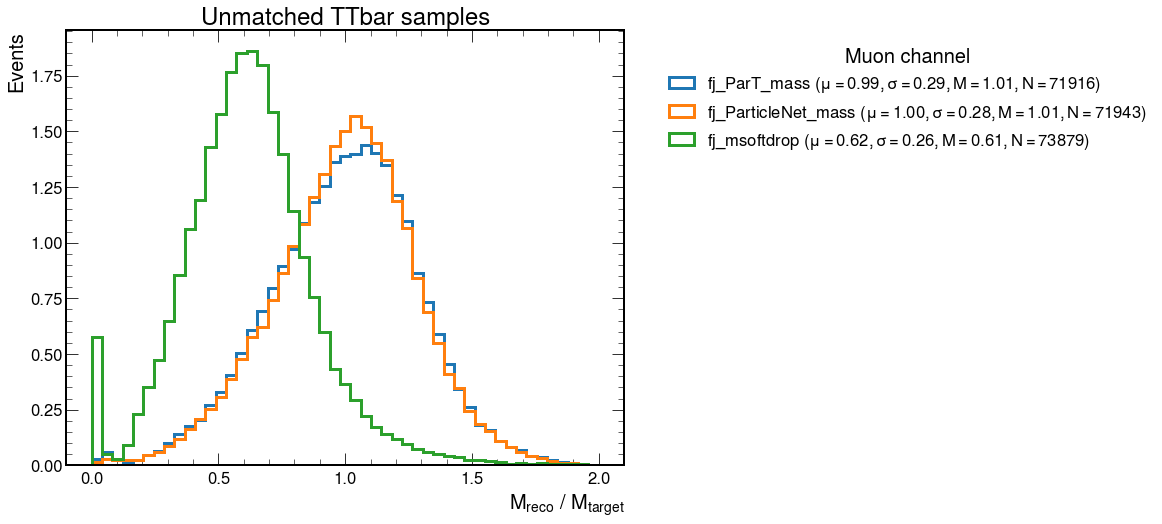

In [465]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

### make plots
fig, ax = plt.subplots(figsize=(10, 8))
bins_ = np.linspace(0,2)

PNs = ["ParT","ParticleNet"]
for pn_version in PNs:
    
    match_bool = (events_dict[ch]["TTbar"]["fj_Top_isMatched"].values == False)

    X = events_dict[ch]["TTbar"][f"fj_{pn_version}_mass"][match_bool].values/125
    is_nan = np.isnan(X)
    if is_nan.sum()!=0:
        print(f"Found {is_nan.sum()} NaN scores out of {len(X)}. Will remove them.")
        X = X[~is_nan]
    
    p = med_iqr(X)
    n_matched = len(X)
    ax.hist(
        X,
        bins_,
        label="fj_{}_mass $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(pn_version, np.mean(X), np.std(X), p[0], n_matched),    
        linewidth=3,
        density=True,
        histtype="step"
        )

X = events_dict[ch]["TTbar"]["fj_msoftdrop"][match_bool].values/125
p = med_iqr(X)
n_matched = len(X)
ax.hist(
    X,
    bins_,
    label="fj_msoftdrop $(\mu={:.2f}, \sigma={:.2f}, M={:.2f}, N={})$".format(np.mean(X), np.std(X), p[0], n_matched),    
    linewidth=3,
    density=True,
    histtype="step"
)  
ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left",)
ax.set_ylabel("Events")
ax.set_xlabel("$M_{reco}$ / $M_{target}$")
ax.set_xticks([0,0.5,1,1.5,2])
ax.set_title(f"Unmatched TTbar samples");

# With tagger cuts

In [491]:
plt.rcParams.update({"font.size": 20})

ch = "mu"

sigs = ["fj_pnversion_probHWqqWmv0c",
         "fj_pnversion_probHWqqWmv1c",
         "fj_pnversion_probHWqqWtauev0c",
         "fj_pnversion_probHWqqWtaumv1c"]

qcds = ["fj_pnversion_probQCDbb",
        "fj_pnversion_probQCDcc",
        "fj_pnversion_probQCDb",
        "fj_pnversion_probQCDc",
        "fj_pnversion_probQCDothers"]

tops = ["fj_pnversion_probTopbWmv",
        "fj_pnversion_probTopbWtaumv"]


def plot_regressed_mass(bkg, PNs, cuts=[0.60, 0.70, 0.80, 0.85, 0.90, 0.95, 0.99]):

    ### regressed mass
    bins_ = np.linspace(0,400)

    for pn_version in PNs:
        new_sigs = [s.replace("pnversion",pn_version) for s in sigs]
        new_qcds = [s.replace("pnversion",pn_version) for s in qcds]    
        new_tops = [s.replace("pnversion",pn_version) for s in tops]

        ### make plots
        for sample in ["HWW", bkg]:

            higgs_score = events_dict[ch][sample][new_sigs].sum(axis=1)

            if bkg == "QCD":
                bkg_score = events_dict[ch][sample][new_qcds].sum(axis=1)                     
            elif bkg == "TTbar":
                bkg_score = events_dict[ch][sample][new_tops].sum(axis=1)         

            disc = higgs_score / (higgs_score+bkg_score)

            fig, ax = plt.subplots(figsize=(6, 4))

            for cut in cuts:

                mass_ = f"fj_{pn_version}_mass"

                ### passing region
                disc_ = disc>cut
                ax.hist(
                    events_dict[ch][sample][mass_][disc_].values,
                    bins_,
                    label=f"score>{cut:.3f} - N={len(events_dict[ch][sample][mass_][disc_].values)}",
                    linewidth=3,
                    density=True,
                    histtype="step",
                    weights=events_dict[ch][sample]["event_weight"][disc_].values
                )    
            plt.axvline(x=125, color='grey', linestyle='--')    
            ax.legend(title=f"{xch} channel", bbox_to_anchor=(1.05, 1), loc="upper left")
            ax.set_ylabel("Events")
            ax.set_xlabel(f"{mass_} (GeV)")
            ax.set_title(f"{sample} sample")

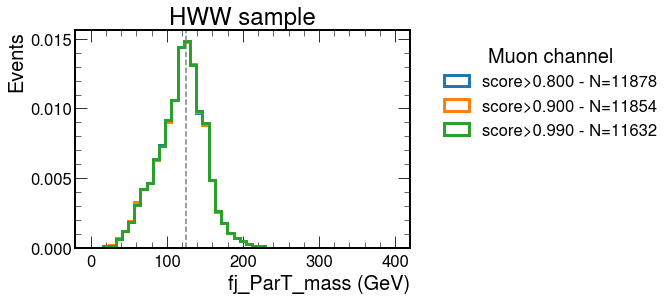

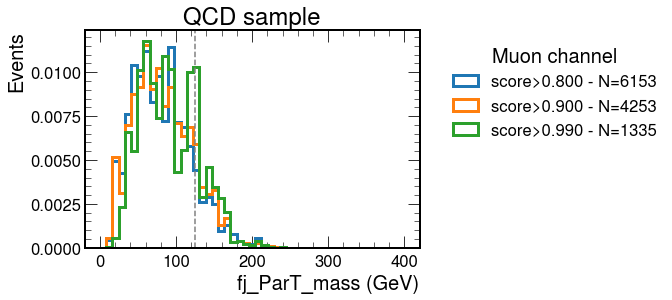

In [492]:
plot_regressed_mass("QCD", ["ParT"], cuts=[0.8,0.9,0.99])

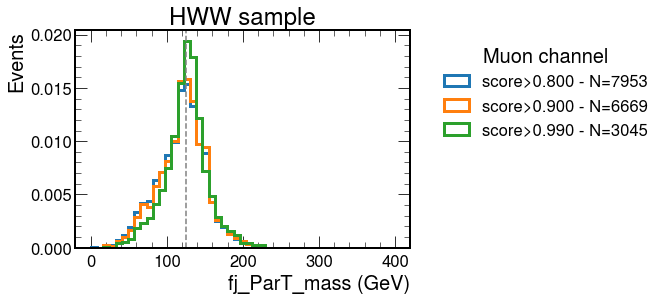

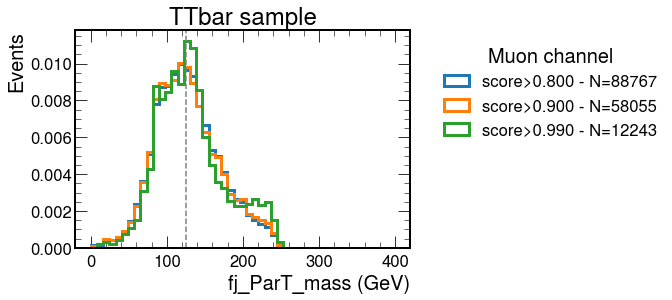

In [493]:
plot_regressed_mass("TTbar", ["ParT"], cuts=[0.8,0.9,0.99])